In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import numpy as np

In [3]:
ds = pd.read_excel('./Relatas_ML_Assignment/sales-pipeline.xlsx')

In [4]:
df = ds.query('Deal_Stage == "Won"')

In [5]:
df['Close Date'] = pd.to_datetime(df['Close Date'])


/home/ai/.virtualenvs/face_deep/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
daily = df.set_index('Close Date')

In [7]:
agg = df.groupby('Close Date')['Close_Value'].sum()

In [9]:
monthly = agg.resample('M').sum()

<AxesSubplot:xlabel='Close Date'>

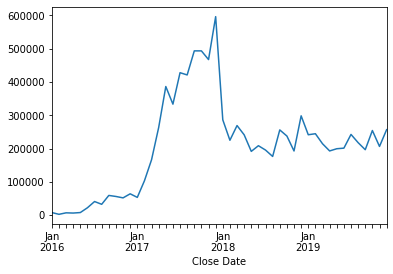

In [10]:
monthly.plot(xticks = monthly.index)

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
data1 = [x + random() for x in range(1, 100)]
data2 = [x + random() for x in range(101, 200)]
# fit model
model = SARIMAX(data1, exog=data2, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
exog2 = [200 + random()]
yhat = model_fit.predict(len(data1), len(data1), exog=[exog2])
print(yhat)

[101.04405996]


/home/ai/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


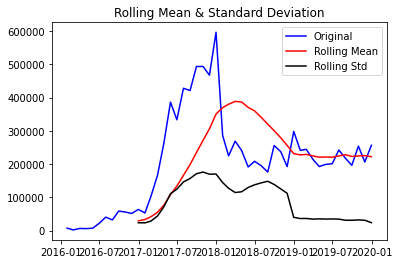

Results of Dickey-Fuller Test:
Test Statistic                 -1.902735
p-value                         0.330776
#Lags Used                      0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


In [10]:
timeseries = monthly
from statsmodels.tsa.stattools import adfuller
    
#Determing rolling statistics
rolmean = pd.Series(timeseries).rolling( window=12).mean()
rolstd = pd.Series(timeseries).rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(timeseries, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(timeseries, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

<AxesSubplot:xlabel='Close Date'>

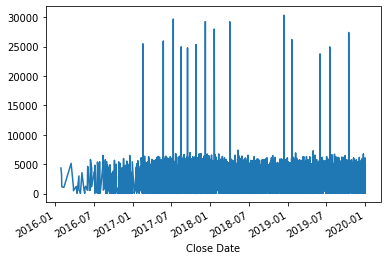

In [11]:
daily['Close_Value'].plot()

In [12]:
weekly = df.resample('W-Mon', on='Close Date').sum().reset_index().sort_values(by='Close Date')


In [13]:
weekly

,Close Date,Close_Value,DateDiff
0,2016-02-01,8703,60
1,2016-02-08,0,0
2,2016-02-15,1070,23
3,2016-02-22,0,0
4,2016-02-29,0,0
...,...,...,...
201,2019-12-09,48464,16160
202,2019-12-16,67665,18632
203,2019-12-23,74491,18346
204,2019-12-30,44930,14450


In [14]:
weekly = weekly.drop(columns="DateDiff")

In [15]:
weekly = weekly.set_index('Close Date')

<AxesSubplot:xlabel='Close Date'>

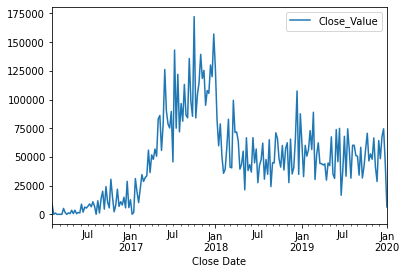

In [16]:
weekly.plot()

/home/ai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


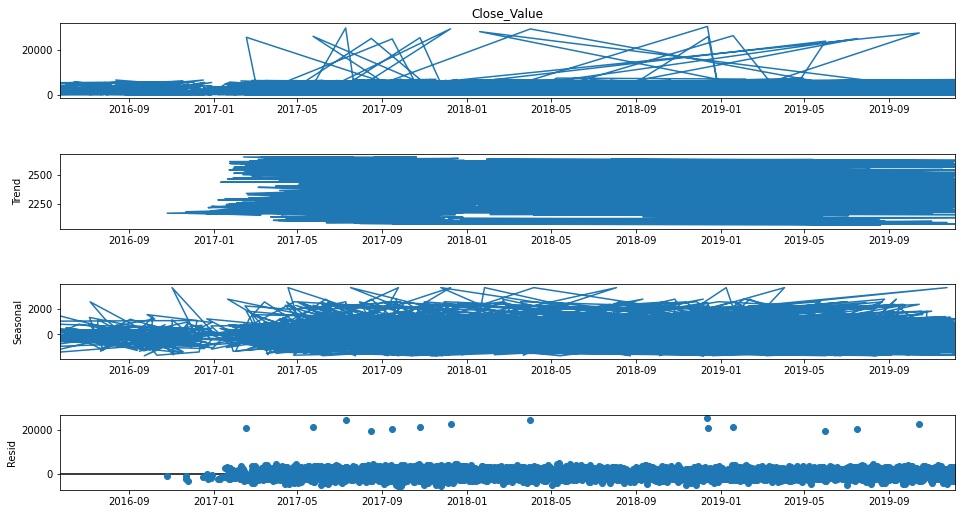

In [26]:
res = sm.tsa.seasonal_decompose(daily_series,freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [42]:
daily['Created Date'] = pd.to_datetime(daily['Created Date'])
daily_series = daily.set_index('Created Date').resample('M')['Close_Value'].sum()

<AxesSubplot:xlabel='Created Date'>

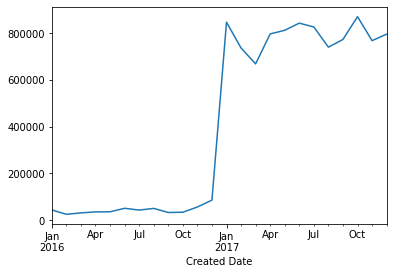

In [44]:
daily_series.plot()

<AxesSubplot:xlabel='Created Date'>

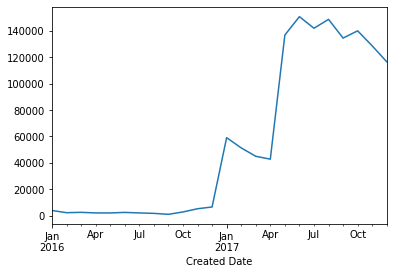

In [56]:
daily.set_index('Created Date').resample('M')['DateDiff'].sum().plot()

In [12]:
import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series = monthly
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=121829.631
ARIMA(0, 1, 1) RMSE=110206.291
ARIMA(0, 1, 2) RMSE=123978.364
ARIMA(0, 1, 4) RMSE=122827.482
ARIMA(0, 2, 1) RMSE=112994.163
ARIMA(0, 2, 2) RMSE=127517.150
ARIMA(1, 0, 0) RMSE=101200.984
ARIMA(1, 1, 0) RMSE=116329.709
ARIMA(1, 2, 0) RMSE=135304.908
ARIMA(2, 0, 0) RMSE=111431.172
ARIMA(2, 1, 0) RMSE=117807.490
ARIMA(2, 2, 0) RMSE=124087.928
ARIMA(3, 0, 0) RMSE=112453.816
ARIMA(3, 1, 0) RMSE=117602.530
ARIMA(3, 2, 0) RMSE=123873.971
ARIMA(4, 0, 0) RMSE=114572.368
ARIMA(4, 1, 0) RMSE=121374.410
Best ARIMA(1, 0, 0) RMSE=101200.984


                   0
count      24.000000
mean   -28629.180081
std     99154.736051
min   -289403.183128
25%    -77564.743099
50%    -23874.411112
75%     13532.396080
max    232856.077017


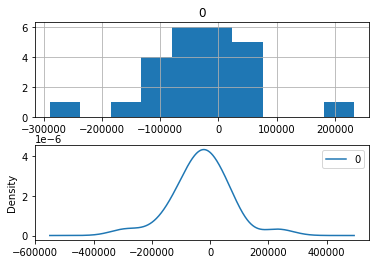

In [13]:
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
#series = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
series = monthly
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	months_in_year = 12
	diff = difference(history, months_in_year)
	# predict
	model = ARIMA(diff, order=(1,0,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, months_in_year)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

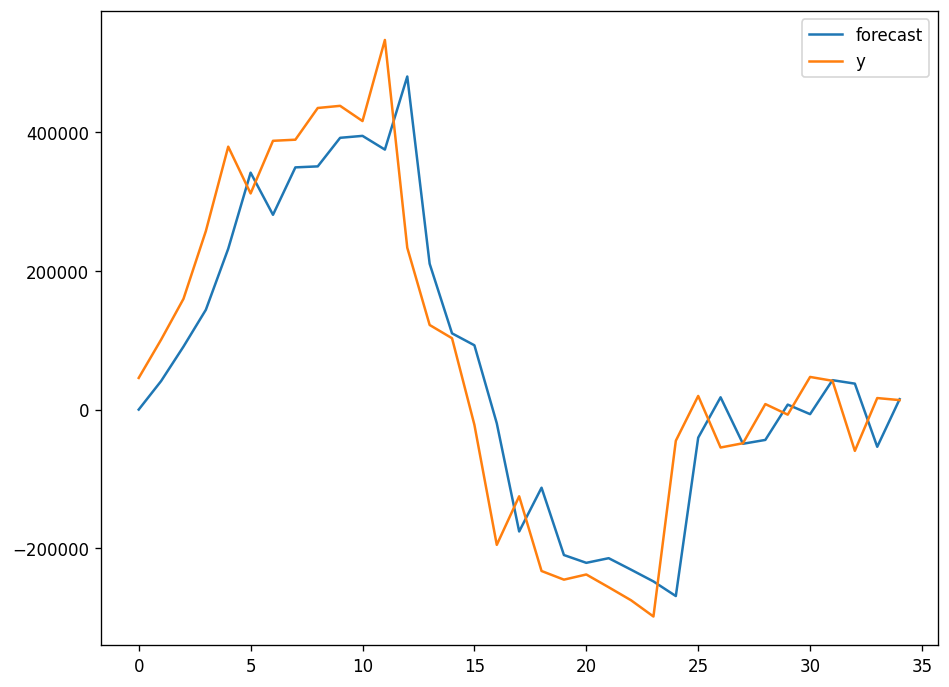

In [32]:
model_fit.plot_predict(dynamic=False)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'value'

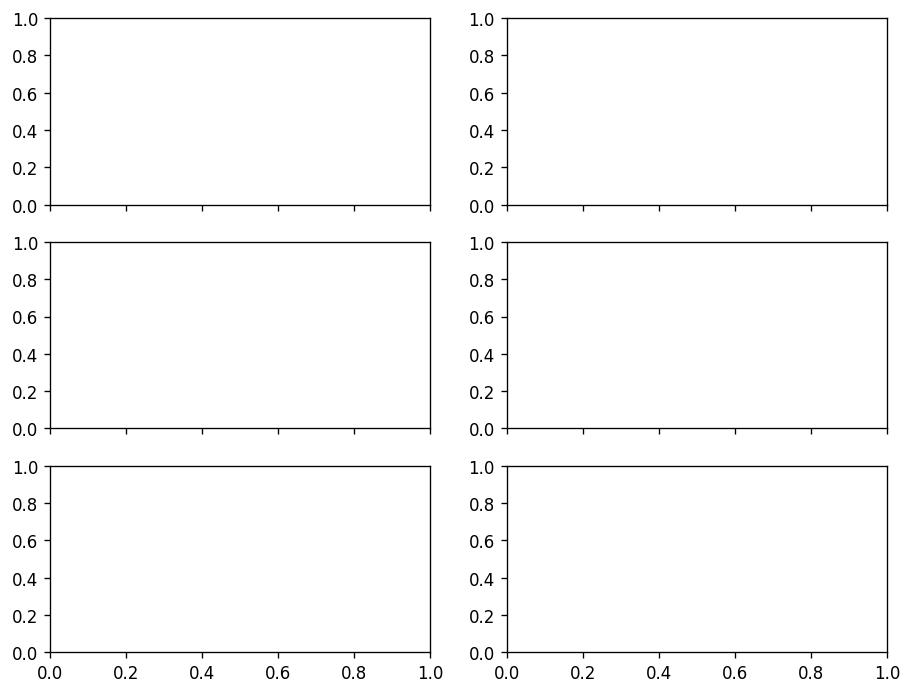

In [19]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
df = monthly
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

<AxesSubplot:xlabel='Close Date'>

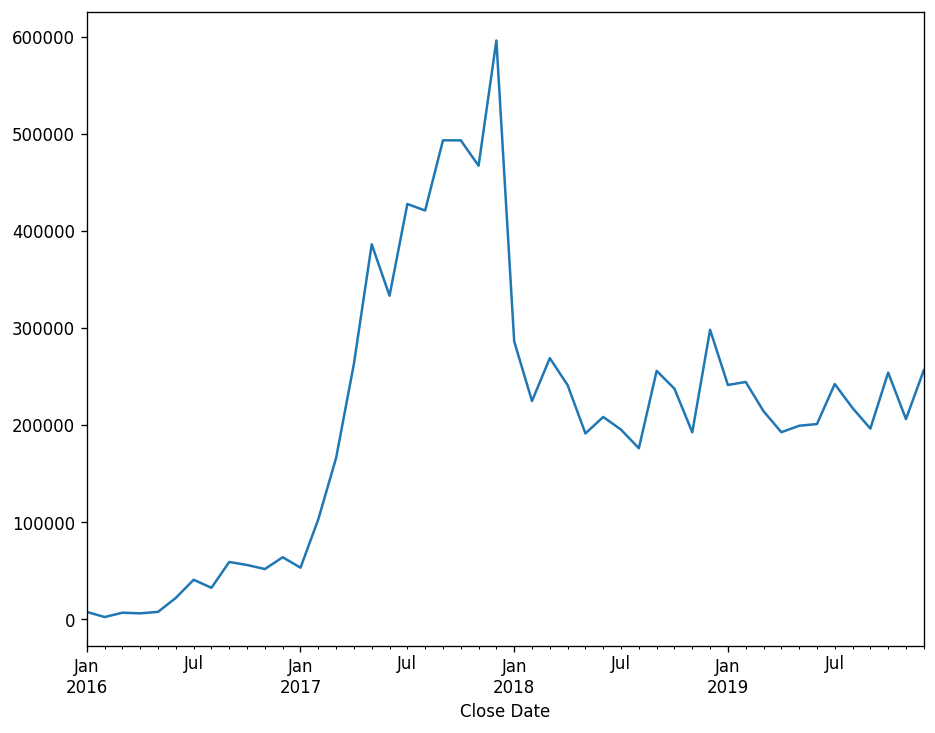

In [31]:
monthly.plot()